In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf 

In [2]:
df = pd.read_excel("preparedData.xlsx")

In [3]:
df.shape

(699, 50)

In [4]:
df.drop(columns=['new_tests','tests_per_case', 'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'total_boosters', 'new_vaccinations',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'life_expectancy', 'human_development_index',
       'covid: (Ireland)', 'COVID-19 testing: (Ireland)',
       'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'book covid test: (Ireland)_y', 'covid test dublin: (Ireland)',
       'covid test centre: (Ireland)', 'hse covid vaccine: (Ireland)',
       'hse vaccine portal: (Ireland)', 'hse portal vaccine: (Ireland)',
       'pcr test hse: (Ireland)', 'hse covid test: (Ireland)',
       'hse vaccine registration: (Ireland)',
       'how long will it take to vaccinate ireland: (Ireland)'], inplace=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,699.0,1750.853462,3401.509976,6.571,285.7145,531.2860,1479.85750,23752.0000
reproduction_rate,699.0,1.079442,0.344792,0.450,0.8800,1.0300,1.25000,2.8400
positive_rate,699.0,0.077215,0.095944,0.000,0.0229,0.0403,0.08965,0.5523


In [6]:
date_time = pd.to_datetime(df.pop('date'), format='%d-%m-%Y')

In [7]:
df.shape

(699, 3)

In [8]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

In [9]:
X_data = X_scaler.fit_transform(df[['reproduction_rate','positive_rate']])

In [10]:
Y_data = Y_scaler.fit_transform(df[['new_cases_smoothed']])

In [11]:
validate = df[['reproduction_rate','positive_rate','new_cases_smoothed']].tail(21)
df.drop(df.tail(21).index,inplace=True)

In [12]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [13]:
hist_window = 21
horizon = 21
TRAIN_SPLIT = 600
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [14]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.86192469 0.        ]
 [0.89539749 0.        ]
 [0.94142259 0.        ]
 [0.9748954  0.        ]
 [1.         0.        ]
 [0.92050209 0.        ]
 [0.85355649 0.        ]
 [0.81171548 0.        ]
 [0.76569038 0.        ]
 [0.71966527 0.        ]
 [0.66945607 0.21166033]
 [0.61506276 0.17164584]
 [0.59414226 0.17617237]
 [0.56903766 0.1913815 ]
 [0.53974895 0.19264892]
 [0.51464435 0.21727322]
 [0.49372385 0.22650733]
 [0.46861925 0.22035126]
 [0.45188285 0.26127105]
 [0.45188285 0.30001811]
 [0.45606695 0.31377874]]

 Target horizon

[[0.014487  ]
 [0.01460736]
 [0.01552783]
 [0.01611742]
 [0.02268108]
 [0.02573729]
 [0.02776475]
 [0.03150682]
 [0.03443673]
 [0.03866609]
 [0.04001372]
 [0.03516466]
 [0.03479769]
 [0.03338992]
 [0.02983433]
 [0.02716312]
 [0.02453407]
 [0.02580951]
 [0.02501534]
 [0.02260288]
 [0.02385423]]


In [15]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [16]:
lstm_model = tf.keras.models.Sequential([
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                            input_shape=x_train.shape[-2:]),
 tf.keras.layers.Dense(20, activation='sigmoid'),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(250, return_sequences=True)),
 tf.keras.layers.Dense(20, activation='sigmoid'),
 tf.keras.layers.Dense(20, activation='sigmoid'),
 tf.keras.layers.Dropout(0.25),
 tf.keras.layers.Dense(units=1),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 21, 400)          324800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 21, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 500)          542000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 21, 20)            10020     
                                                                 
 dense_2 (Dense)             (None, 21, 20)            420       
                                                                 
 dropout (Dropout)           (None, 21, 20)            0

In [17]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0, patience=10,
                                                  verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 

history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100
                         ,validation_data=val_data,validation_steps=50,
                         verbose=1,callbacks=callbacks)

Epoch 1/150
100/100 [==============================] - 15s 118ms/step - loss: 0.0600 - val_loss: 0.2311
Epoch 2/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0193 - val_loss: 0.2321
Epoch 3/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0099 - val_loss: 0.2325
Epoch 4/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0065 - val_loss: 0.2332
Epoch 5/150
100/100 [==============================] - 11s 106ms/step - loss: 0.0049 - val_loss: 0.2324
Epoch 6/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0040 - val_loss: 0.2321
Epoch 7/150
100/100 [==============================] - 11s 106ms/step - loss: 0.0034 - val_loss: 0.2330
Epoch 8/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0031 - val_loss: 0.2327
Epoch 9/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0028 - val_loss: 0.2330
Epoch 10/150
100/100 [==============================] - 11s 107m

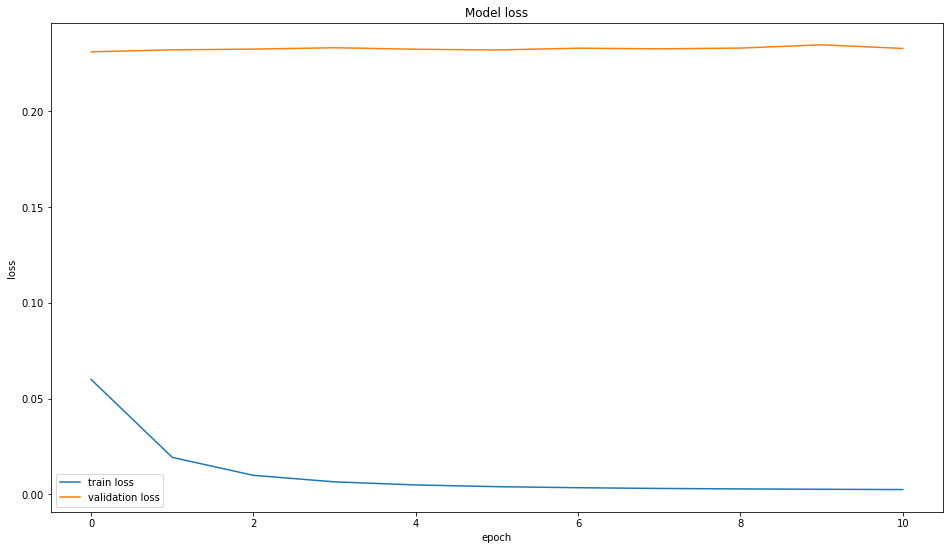

In [18]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [19]:
df_val = X_scaler.fit_transform(df[['reproduction_rate','positive_rate']].tail(7))
val_rescaled = df_val.reshape(1, df_val.shape[0], df_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

ValueError: in user code:

    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/simonmclain/miniforge3/envs/tf24/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 21, 2), found shape=(None, 7, 2)


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
pred_Inverse[0]


In [ ]:
timeseries_evaluation_metrics_func(validate['new_cases_smoothed'],pred_Inverse[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['new_cases_smoothed']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("new_cases_smoothed")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
#https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

In [ ]:
#https://analyticsindiamag.com/how-to-do-multivariate-time-series-forecasting-using-lstm/
# training using this model
#https://github.com/christianversloot/machine-learning-articles/blob/main/implementing-relu-sigmoid-and-tanh-in-keras.md

In [ ]:
#https://github.com/search?l=Python&q=time+series+covid+prediction&type=Repositories